# SVI (Stochastic Variational Inference)

pyro以SVI作为其通用的inference algorithm。

$$p_{\theta}(X, Z)=p_{\theta}(X|Z)p_{\theta}(Z)$$

其中$X$表示观测，$Z$表示latent random variables，$\theta$是parameters。

组成$p_{\theta}$的$p_i$需要服从下面3个条件：

1. 我们可以从$p_i$中进行采样；
2. 可以计算每个点上的log pdf $p_i$;
3. $p_i$相对于参数$\theta$是可微分的。

我们现在的目标是：

$$\theta_{max}=argmax_{\theta}{\log p_{\theta}(X)}=\int{dZp_{\theta}(X,Z)}$$

并且得到一个基于最优theta值的后验分布：

$$p_{\theta_{max}}(Z|X)=\frac{p_{\theta_{max}}(X,Z)}{\int{dZp_{\theta_{max}}(X,Z)}}$$

其实最大的问题都在于那个积分是难以解决的。VI提供了一种解决方法。

## guide

基本思想是借助一个变分分布$q_{\phi}(Z)$，这在pyro中称为guide。它是最优后验分布$p_{\theta_{max}}(Z|X)$的近似。

在pyro中，这个guide也被使用`pyro.sample`来编写成一个随机函数，也就是model。其不包含observed data，但必须和真实的model拥有相同的输入。同时$Z$需要在model和guide中拥有相同的名称。

## ELBO

简单的推断可以得到下面的等式：

$$\log{p_{\theta}(X)} = ELBO + KL(q_{\phi}(Z)||p_{\theta}(Z|X))$$

其中

$$ELBO = \mathbb{E}_{q_{\phi}(Z)}[\log{p_{\theta}(X,Z)}-\log{q_{\phi}(Z)}]$$

1. 我们首先固定theta、改变phi来最大化ELBO，则其实就是最小化q和后验之间的KL散度。最终，ELBO就是$\log{p_{\theta}(X)}$。
2. 然后我们再固定phi、改变theta来最大化ELBO，这是就是最大化$\log{p_{\theta}(X)}$。

上述过程交替进行，最后得到我们想要得到的结果。但实际上可能是同时改变phi和theta来最大化ELBO（VAE实际上就是这么做的），这样依然可能得到我们想要的值。

## Optimizer

从上面我们看到，每一步还需要一个梯度下降优化器来最大化ELBO。pyro wraps了一下pytorch中的optimizer，在`pyro.optim`中，可以用于我们的最优化。

调用的方式有两种：

第一种是比较通用的，将优化器的参数包装成字典，传入优化器类即可。

In [6]:
from pyro.optim import Adam

adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)

第二种方式是传入一个callble，传入两个参数（`module_name`和`param_name`），返回的是参数字典。其可以提供更加细致的操作，比如对于不同的参数，使用不同的学习率。

In [7]:
def per_param_callable(module_name, param_name):
    if param_name == "my_special_parameter":
        return {"lr": 0.010}
    else:
        return {"lr": 0.001}
optimizer = Adam(per_param_callable)

## `SVI` class

`SVI`类是进行SVI的类。其基本调用方式是：

```python
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
```

其提供两个重要的方法：

1. `step()`，其接受的参数会被传递到`model`和`guide`。其主要作用是计算梯度并进行一次参数更新。其返回的是loss。
2. `evaluate_loss()`，其接受的参数和`step()`相同，但不会进行梯度更新，只是返回计算的loss。

## A simple example

我们现在使用一个例子来实现一下整个过程。

这个例子就是coin模型，我们对一个coin多次试验，得到其head or tail的一系列数据，然后希望知道该硬币是否是fair的。

In [3]:
import torch

data = torch.cat([torch.ones(6), torch.zeros(4)])
data

tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.])

In [5]:
import pyro
import pyro.distributions as dist

def model(data):
    fairness = pyro.sample("fair", dist.Beta(torch.tensor(10.0), torch.tensor(10.0)))
    with pyro.plate("plate1"):
        s = pyro.sample("obs", dist.Bernoulli(fairness), obs=data)
    return s

model(data)

tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.])

In [22]:
from pyro.distributions import constraints

def guide(data):
    alpha = pyro.param("alpha", torch.tensor(15.), constraint=constraints.positive)
    beta = pyro.param("beta", torch.tensor(15.), constraint=constraints.positive)
    return pyro.sample("fair", dist.Beta(alpha, beta))

guide(None)

tensor(0.5932, grad_fn=<SelectBackward>)

In [26]:
# 我故意将初始参数设置的距离真实值非常远，所以其需要进行大量的训练才能找到真实的值（注意，之所以需要大量的训练是因为我们不能将lr设的太大）
# 设的太远想要收敛比较难，还是使用原始的值把

pyro.clear_param_store()  # param的迭代从头开始
optimizer = pyro.optim.Adam({"lr": 0.0005, "betas": (0.90, 0.999)})

svi = pyro.infer.SVI(model, guide, optimizer, pyro.infer.Trace_ELBO())

n_steps = 5000
losses, alphas, betas = [], [], []
for s in range(n_steps):
    loss = svi.step(data)
    if s % 10 == 0:
        losses.append(loss)
        alphas.append(pyro.param("alpha").item())
        betas.append(pyro.param("beta").item())
    if s % 1000 == 0:
        print("step %d complete. Now loss is %.4f" % (s, loss))

step 0 complete. Now loss is 7.2335
step 1000 complete. Now loss is 7.0169
step 2000 complete. Now loss is 7.1463
step 3000 complete. Now loss is 7.1547
step 4000 complete. Now loss is 7.0653


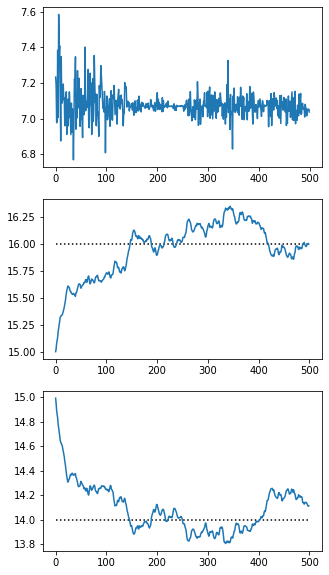

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(5, 10))

axes[0].plot(losses)
axes[1].plot([0, len(alphas)], [16, 16], "k:")
axes[1].plot(alphas)
axes[2].plot([0, len(betas)], [14, 14], "k:")
axes[2].plot(betas)

可以看到，我们参数确实收敛到了其真实值附近。

之后可以通过lr_schedual来进一步随着迭代降低lr，来实现更加有效的学习。